In [3]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import lib
import optax

import lib

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
time_delay_dim = 10
time_delay = 5
time_range = (0, 1200, 0.02)
n_centers = 500

In [5]:
n_sins = 100
np.random.seed(12345)
periods = np.random.uniform(5, 50, n_sins)
coeffs = np.random.uniform(0, 1, n_sins)
phases = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_train = lib.stimulus.sinusoidals_stimulus(time_range, amplitude=30, periods=periods, coeffs=coeffs, phases=phases)

neuron_train = lib.neuron.single_neuron_odeint(time_range, stimulus_train.stimulus_list, neuron_initial_state=[0, 0, 0, 0])
neuron_train.generate_sol()

In [6]:
drop_first_n_points = 5000  # drop a few points at the beginning to exclude effects of the choice of initial states
neuron_train.sol = neuron_train.sol[drop_first_n_points:]
stimulus_train.stimulus_list = stimulus_train.stimulus_list[drop_first_n_points:]

Text(0, 0.5, 'V(t) exact')

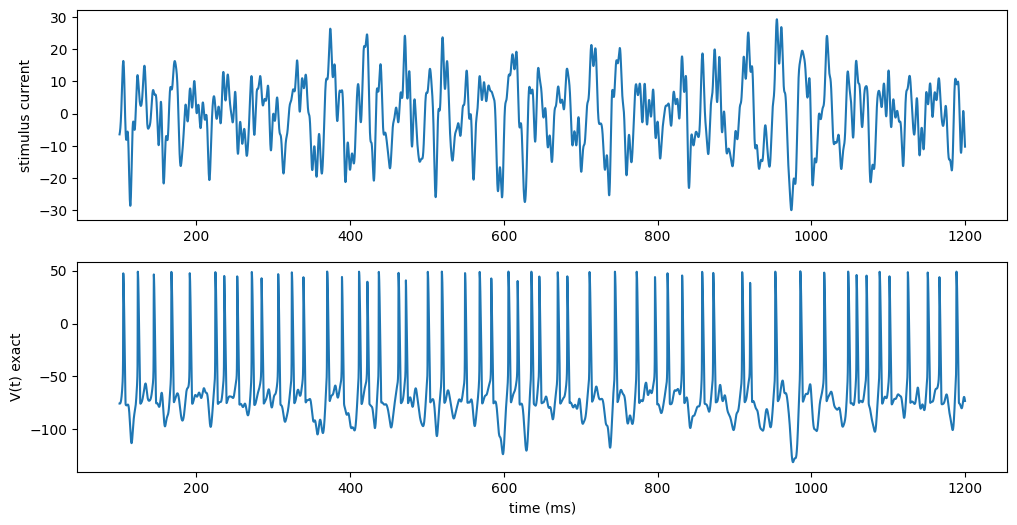

In [7]:
"""plot training data"""
fig, axes = plt.subplots(2, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], stimulus_train.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], neuron_train.sol[:, 0])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("V(t) exact")

Text(0.5, 0, 'time (ms)')

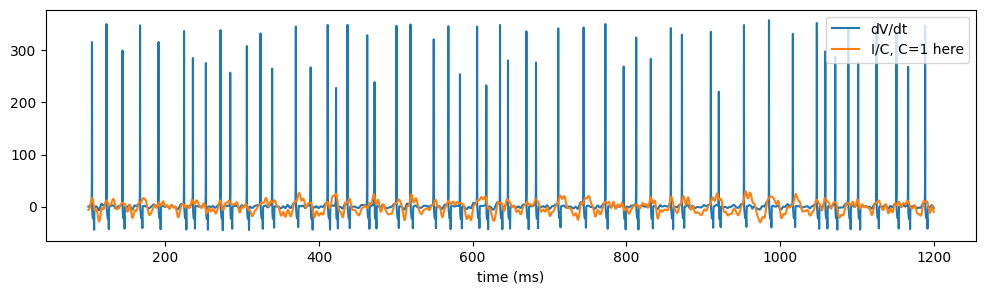

In [9]:
"""Around spikes, dV/dt is much larger than I/C"""
plt.figure(figsize=(12, 3))
plt.plot(np.arange(*time_range)[drop_first_n_points:-1], (neuron_train.sol[1:, 0]-neuron_train.sol[:-1, 0])/2/time_range[-1], label="dV/dt")
plt.plot(np.arange(*time_range)[drop_first_n_points:-1], stimulus_train.stimulus_list[:-1], label="I/C, C=1 here")
plt.legend()
plt.xlabel("time (ms)")

Text(0, 0.5, 'V(t-tau)')

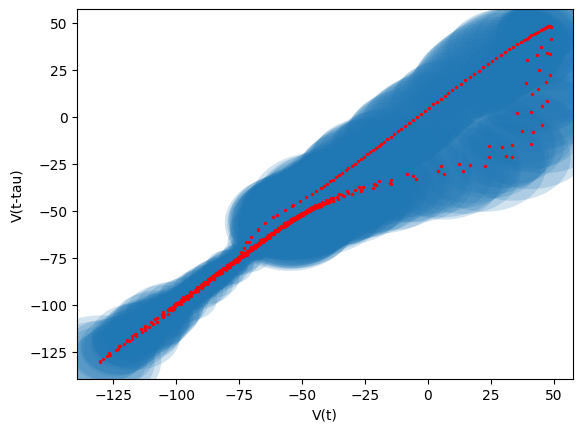

In [10]:
"""get centers and R, plot centers and the range of each center"""
centers, R = lib.train.get_centers_and_R(neuron_train.sol[:, 0], time_delay, time_delay_dim, n_centers, n_neighbors=8)
for i in range(len(centers)):
    circle = plt.Circle((centers[i, 1], centers[i, 0]), radius=np.sqrt(1/R[i]), alpha=0.2, edgecolor='none')
    plt.gca().add_artist(circle)
plt.scatter(centers[:, 1], centers[:, 0], s=2, c="red")
plt.xlabel("V(t)")
plt.ylabel("V(t-tau)")

In [11]:
"""RBF part training by regression"""
beta = 0
regression_train = lib.train.train_by_regression(centers, neuron_train.sol[:, 0], stimulus_train.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R, fixed_C=True, weight_C=1.0) # set fixed_C to True if weight_C should be learned by regression. 
(weights_rbf, weights_leak, weight_C_inverse) = regression_train.get_weights(solver="sparse_cg")

In [12]:
print("1/C: ", weight_C_inverse, "\nA+BV, A, B:", weights_leak)
error_list = regression_train.get_error_list()
error_list = error_list*time_range[-1]
print("max abs voltage error:", np.max(np.abs(error_list)))
print("mean abs voltage error:", np.mean(np.abs(error_list)))
print("ridge regression score: ", regression_train.score)

1/C:  1.0 
A+BV, A, B: [-11.748328   -0.4690719]
max abs voltage error: 1.3637195
mean abs voltage error: 0.0599397
ridge regression score:  0.9887737638414635


In [13]:
mlp = lib.models.mlps()
pred_model = lib.models.prediction_model(time_range[-1], R, centers, weights_rbf, mlp, weights_leak, weight_C_inverse)
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros(time_delay_dim,), jnp.zeros(time_delay_dim, ))
params0 = params

In [14]:
"""Backpropagtion training. First, use a small batch size"""
BP_train_fast = lib.train.train_by_BP(stimulus_train.stimulus_list, neuron_train.sol[:, 0], pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range, batch_size=5000)
BP_train_fast.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_fast.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [01:16<00:00, 26.19it/s, loss=0.00033737178]


In [15]:
"""Backpropagtion training. Second, use a large batch size"""
BP_train_slow = lib.train.train_by_BP(stimulus_train.stimulus_list, neuron_train.sol[:, 0], pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range, batch_size=54000)
BP_train_slow.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_slow.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [08:39<00:00,  3.85it/s, loss=9.245095e-05]  


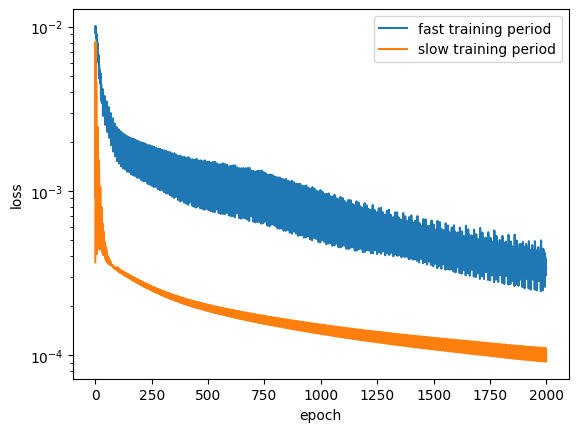

In [17]:
"""plot loss curve"""
plt.plot(BP_train_fast.loss_list[0:], label="fast training period")
plt.plot(BP_train_slow.loss_list[0:], label="slow training period")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

In [52]:
"""data prepartion for prediction test"""
n_prediction_steps = 40000
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100 # set to any number that is larger enough to avoid effects of initial states. 

# test data set
time_spacing = time_range[2]
time_range_test = (0, int((drop_first_n_points + 2*initial_piece_len + n_prediction_steps + prediction_start_after)*time_spacing)+1, time_spacing)

# ------------------ test data 1 --------------------
# a linear combination of harmonics, just like the training data, but with a different random seed
n_sins = 100
np.random.seed(101010)
periods_test1 = np.random.uniform(5, 50, n_sins)
coeffs_test1 = np.random.uniform(0, 1, n_sins)
phases_test1 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test1 = lib.stimulus.sinusoidals_stimulus(time_range_test, amplitude=30, periods=periods_test1, coeffs=coeffs_test1, phases=phases_test1)

test_neuron1 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test1.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron1.generate_sol()
test_neuron1.sol = test_neuron1.sol[drop_first_n_points:]
stimulus_test1.stimulus_list = stimulus_test1.stimulus_list[drop_first_n_points:]
initial_piece_test1 = test_neuron1.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test1 = stimulus_test1.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 1 generated!")

# ------------------ test data 2 --------------------
# a linear combination of harmonics, harmonics with larger periods have larger amplitudes
n_sins = 100
np.random.seed(0)
periods_test2 = np.random.uniform(5, 50, n_sins)
periods_test2 = periods_test2[np.argsort(np.abs(periods_test2))]
coeffs_test2 = np.random.uniform(0, 1, n_sins)
coeffs_test2 = coeffs_test2[np.argsort(np.abs(coeffs_test2))]
phases_test2 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test2 = lib.stimulus.sinusoidals_stimulus(time_range_test, amplitude=30, periods=periods_test2, coeffs=coeffs_test2, phases=phases_test2)

test_neuron2 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test2.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron2.generate_sol()
test_neuron2.sol = test_neuron2.sol[drop_first_n_points:]
stimulus_test2.stimulus_list = stimulus_test2.stimulus_list[drop_first_n_points:]
initial_piece_test2 = test_neuron2.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test2 = stimulus_test2.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 2 generated!")

# ------------------ test data 3 --------------------
# a linear combination of harmonics, harmonics with larger periods have smaller amplitudes
n_sins = 100
np.random.seed(0)
periods_test3 = np.random.uniform(5, 50, n_sins)
periods_test3 = periods_test3[-np.argsort(np.abs(periods_test3))]
coeffs_test3 = np.random.uniform(0, 1, n_sins)
coeffs_test3 = coeffs_test3[np.argsort(np.abs(coeffs_test3))]
phases_test3 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test3 = lib.stimulus.sinusoidals_stimulus(time_range_test, amplitude=30, periods=periods_test3, coeffs=coeffs_test3, phases=phases_test3)

test_neuron3 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test3.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron3.generate_sol()
test_neuron3.sol = test_neuron3.sol[drop_first_n_points:]
stimulus_test3.stimulus_list = stimulus_test3.stimulus_list[drop_first_n_points:]
initial_piece_test3 = test_neuron3.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test3 = stimulus_test3.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 3 generated!")

# ------------------ test data 4 --------------------
# Lorenz63 X data
stimulus_test4 = lib.stimulus.lorenz1963_stimulus(time_range=time_range_test, initial_state=[-3.3, -3.0, 22], rescale_factor=1.5)
stimulus_test4.get_stimulus_list()
test_neuron4 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test4.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron4.generate_sol()
test_neuron4.sol = test_neuron4.sol[drop_first_n_points:]
stimulus_test4.stimulus_list = stimulus_test4.stimulus_list[drop_first_n_points:]
initial_piece_test4 = test_neuron4.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test4 = stimulus_test4.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 4 generated!")

# ------------------ test data 5 --------------------
# a linear combination of harmonics, the periods are sampled from 20 ms to 90 ms
n_sins = 100
np.random.seed(0)
periods_test5 = np.random.uniform(20, 90, n_sins)
coeffs_test5 = np.random.uniform(0, 1, n_sins)
phases_test5 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test5 = lib.stimulus.sinusoidals_stimulus(time_range_test, amplitude=30, periods=periods_test5, coeffs=coeffs_test5, phases=phases_test5)

test_neuron5 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test5.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron5.generate_sol()
test_neuron5.sol = test_neuron5.sol[drop_first_n_points:]
stimulus_test5.stimulus_list = stimulus_test5.stimulus_list[drop_first_n_points:]
initial_piece_test5 = test_neuron5.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test5 = stimulus_test5.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 5 generated!")

# ------------------ test data 6 --------------------
# Colpitts X data, time constant = 15
stimulus_test6= lib.stimulus.colpitts_stimulus(time_range=time_range_test, initial_state=[0.1, 0.1, 0.1], rescale_factor=0.7, time_constant=15)
stimulus_test6.get_stimulus_list()
test_neuron6 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test6.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron6.generate_sol()
test_neuron6.sol = test_neuron6.sol[drop_first_n_points:]
stimulus_test6.stimulus_list = stimulus_test6.stimulus_list[drop_first_n_points:]
initial_piece_test6 = test_neuron6.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test6 = stimulus_test6.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 6 generated!")

# ------------------ test data 7 --------------------
# Colpitts X data, time constant = 3
stimulus_test7= lib.stimulus.colpitts_stimulus(time_range=time_range_test, initial_state=[0.1, 0.1, 0.1], rescale_factor=0.7, time_constant=3)
stimulus_test7.get_stimulus_list()
test_neuron7 = lib.neuron.single_neuron_odeint(time_range_test, stimulus_test7.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron7.generate_sol()
test_neuron7.sol = test_neuron7.sol[drop_first_n_points:]
stimulus_test7.stimulus_list = stimulus_test7.stimulus_list[drop_first_n_points:]
initial_piece_test7 = test_neuron7.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test7 = stimulus_test7.stimulus_list[prediction_start_after+initial_piece_len:]
print("test data 7 generated!")

batch_initial_piece = jnp.array([initial_piece_test1, initial_piece_test2, initial_piece_test3, initial_piece_test4, initial_piece_test5, initial_piece_test6, initial_piece_test7])
batch_stimulus_list_len = min(len(stimulus_list_test1), len(stimulus_list_test2), len(stimulus_list_test3), len(stimulus_list_test4), len(stimulus_list_test5), len(stimulus_list_test6), len(stimulus_list_test7))
batch_stimulus_list = jnp.array([stimulus_list_test1[:batch_stimulus_list_len], stimulus_list_test2[:batch_stimulus_list_len], stimulus_list_test3[:batch_stimulus_list_len], stimulus_list_test4[:batch_stimulus_list_len], stimulus_list_test5[:batch_stimulus_list_len], stimulus_list_test6[:batch_stimulus_list_len], stimulus_list_test7[:batch_stimulus_list_len]])

test data 1 generated!
test data 2 generated!
test data 3 generated!
test data 4 generated!
test data 5 generated!
test data 6 generated!
test data 7 generated!


In [53]:
"""prediction with RBF + ANN model"""
pred_run1_batch = lib.time_series_prediction(pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run1_batch.run(params, n_steps=n_prediction_steps)

100%|██████████| 40000/40000 [1:05:40<00:00, 10.15it/s]


In [57]:
"""prediction with RBF only model"""
pred_model_rbf_only = lib.models.prediction_model_no_ann(time_range[-1], R, centers, weights_rbf, mlp, weights_leak, weight_C_inverse)
pred_run0_batch = lib.time_series_prediction(pred_model_rbf_only, time_delay, time_delay_dim, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run0_batch.run(params, n_steps=n_prediction_steps)

100%|██████████| 40000/40000 [07:55<00:00, 84.15it/s]


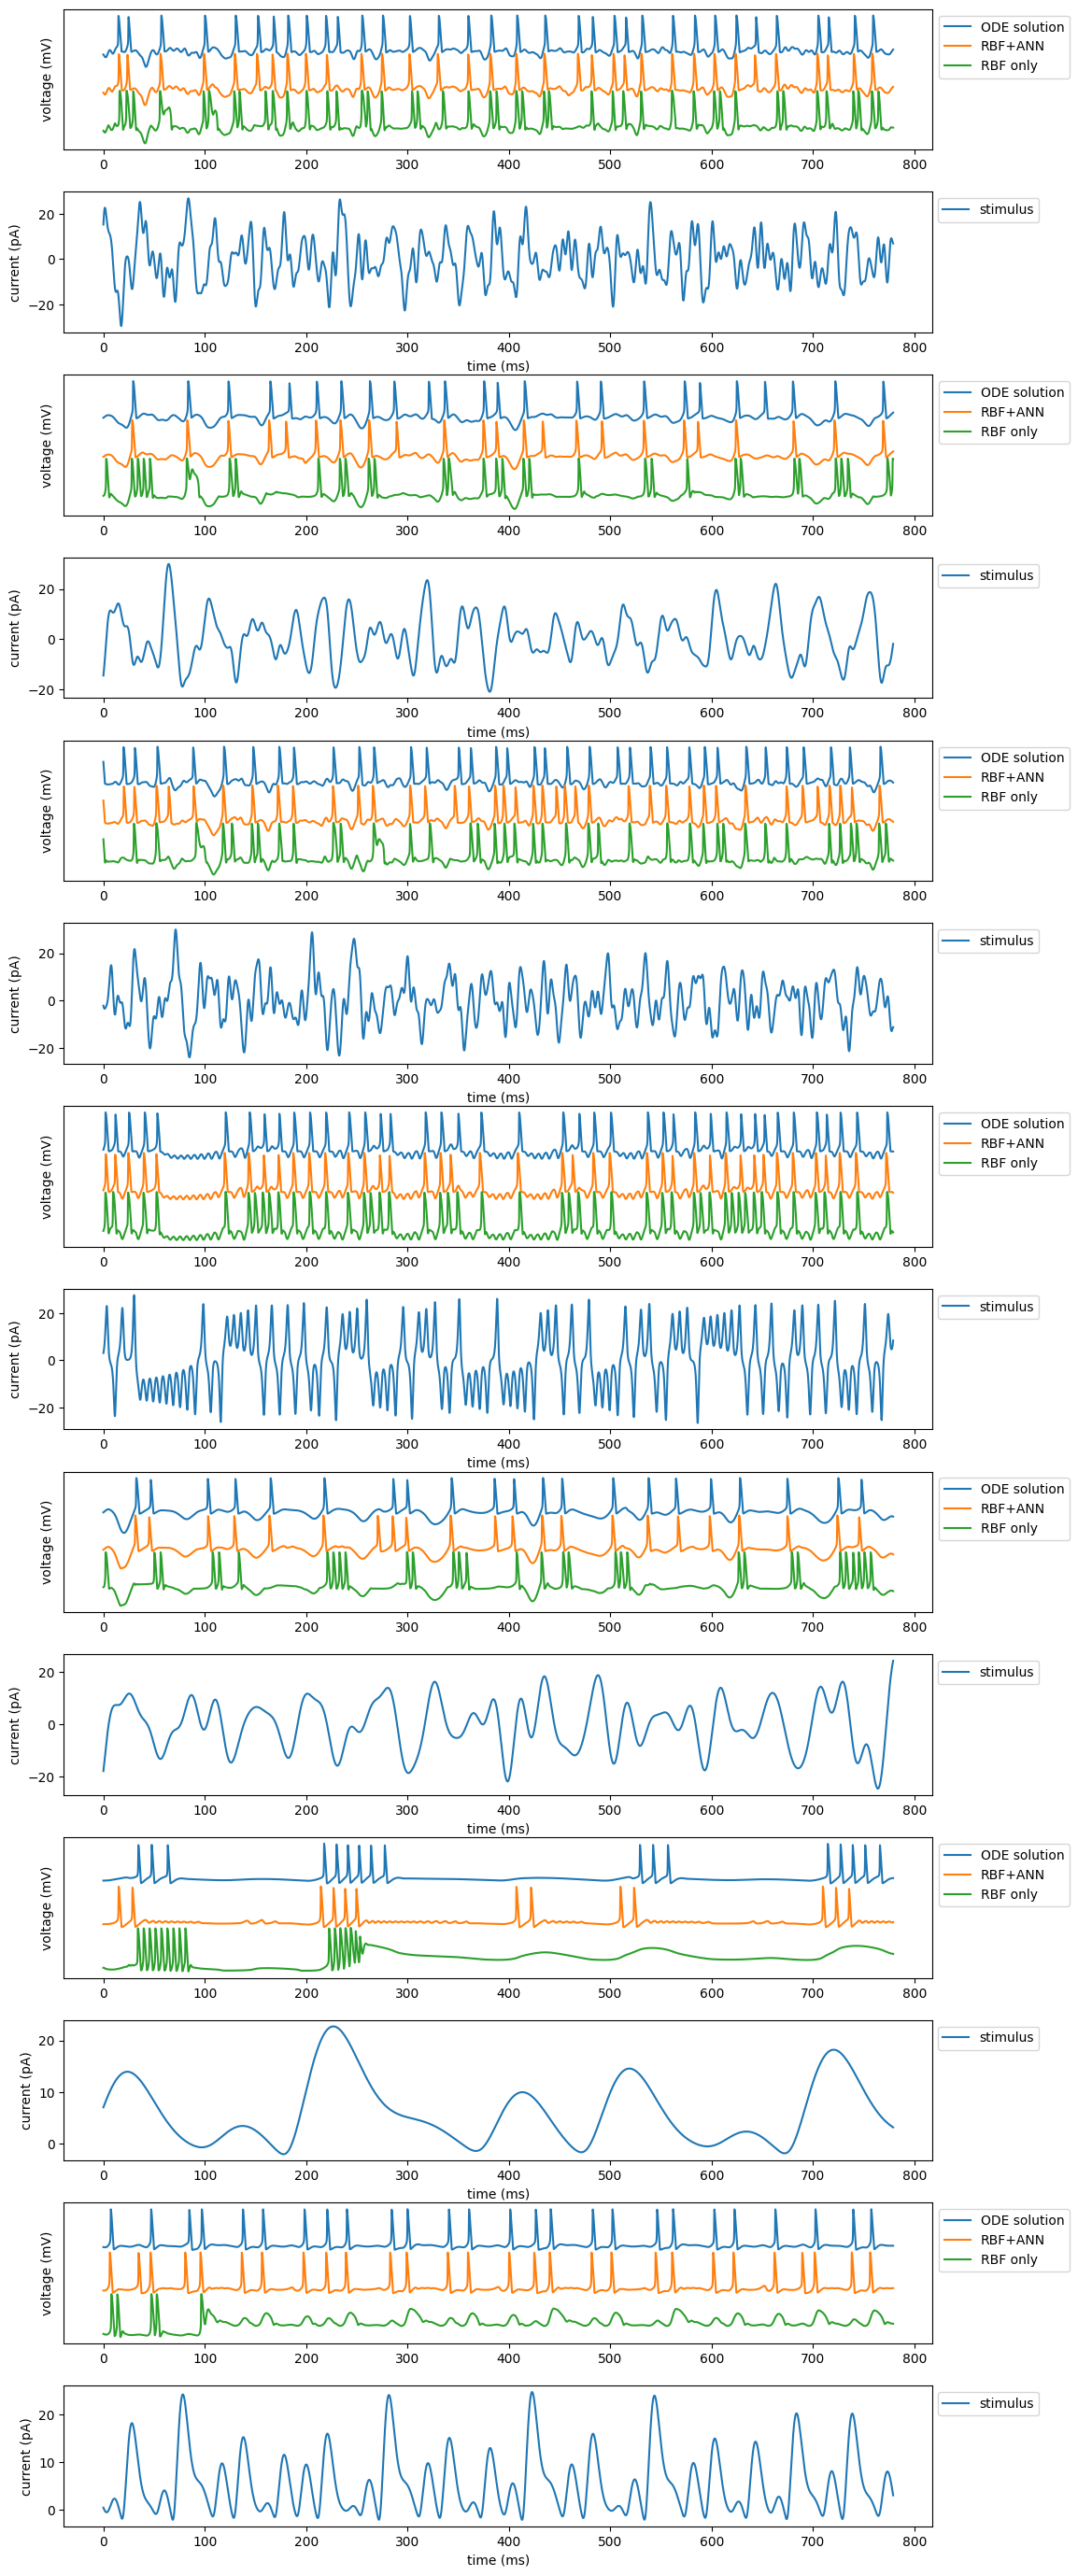

In [58]:
"""plot tests results"""
n_tests = 7
test_neuron_list = [test_neuron1, test_neuron2, test_neuron3, test_neuron4, test_neuron5, test_neuron6, test_neuron7]

start = initial_piece_len + -initial_piece_len 
end = min(batch_stimulus_list.shape[-1]-prediction_start_after, initial_piece_len + n_prediction_steps)

fig, axes = plt.subplots(2*n_tests, 1, figsize=(12, 5*n_tests))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(n_tests):
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), test_neuron_list[i].sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run1_batch.prediction_list[i, start:end]-130, label="RBF+ANN")
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run0_batch.prediction_list[i, start:end]-260, label="RBF only")
    axes[2*i].set_yticks([])
    axes[2*i].set_ylabel("voltage (mV)")
    # axes[2*i].set_ylim(-440, 100)
    axes[2*i].legend(bbox_to_anchor=(1,1))
    
    axes[2*i+1].plot(np.arange(0, (end-start)*time_spacing, time_spacing), batch_stimulus_list[i, prediction_start_after+start: prediction_start_after+end], label="stimulus")
    axes[2*i+1].set_xlabel("time (ms)")
    axes[2*i+1].set_ylabel("current (pA)")
    axes[2*i+1].legend(bbox_to_anchor=(1.13,1))